# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.71KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

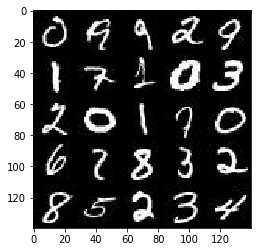

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

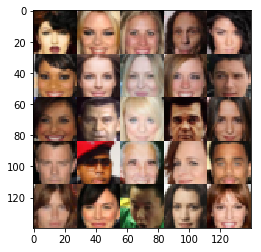

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),  name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (), name="lr")
    return real_input_images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 (or 28x28x1)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.5134
Epoch 1/2... Discriminator Loss: 2.6024... Generator Loss: 0.1175
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.6701
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 2.8166
Epoch 1/2... Discriminator Loss: 0.7055... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 4.5491
Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 1.5036
Epoch 1/2... Discriminator Loss: 0.3358... Generator Loss: 2.1023
Epoch 1/2... Discriminator Loss: 0.2486... Generator Loss: 1.9876


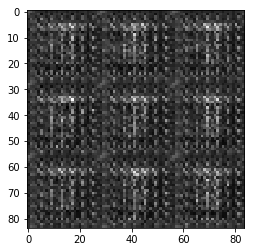

Epoch 1/2... Discriminator Loss: 1.5282... Generator Loss: 8.7786
Epoch 1/2... Discriminator Loss: 0.3964... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 1.2857
Epoch 1/2... Discriminator Loss: 0.4900... Generator Loss: 1.6052
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 0.8360... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 0.6587... Generator Loss: 1.3854
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.9047
Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 1.1525


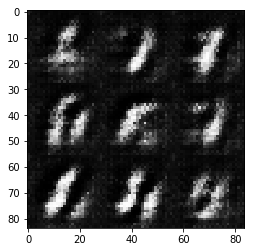

Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.3659
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.2202
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 1.2420
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.3607


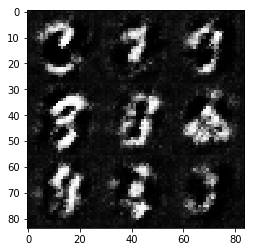

Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 1.7851
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.1965
Epoch 1/2... Discriminator Loss: 0.8382... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.2911
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.4872
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 1.2393
Epoch 1/2... Discriminator Loss: 0.8040... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 1.5435
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.4656


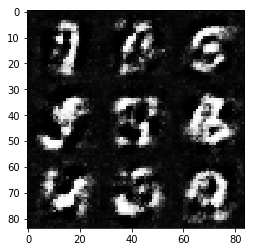

Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 0.6789... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 1.6736
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.5452
Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 1.9060
Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 1.2519
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 2.0227
Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 2.1981


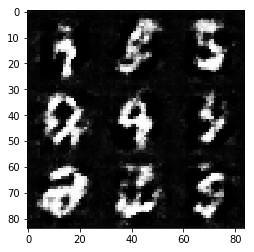

Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.1190
Epoch 1/2... Discriminator Loss: 0.7222... Generator Loss: 2.7275
Epoch 1/2... Discriminator Loss: 0.5020... Generator Loss: 1.5466
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.0302
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 1.1073
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 1.7546
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 3.0906
Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 1.3791
Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 1.2433
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 1.2535


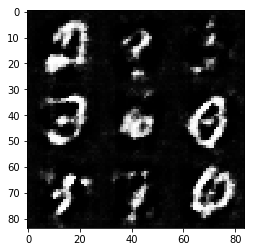

Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 2.8812
Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 1.9100
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 0.4510... Generator Loss: 1.8463
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 2.2947
Epoch 1/2... Discriminator Loss: 0.5569... Generator Loss: 1.7043
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 2.9405
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.7628
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 0.9762


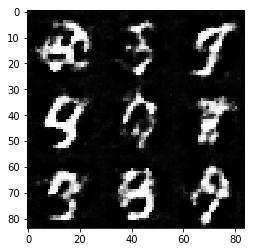

Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 2.5258
Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 0.7164... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 2.1223
Epoch 1/2... Discriminator Loss: 0.6500... Generator Loss: 1.1425
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.7858
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 1.5103
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 2.7437


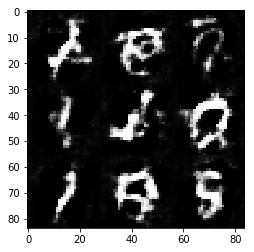

Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.1711
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 1.3568
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 0.7939


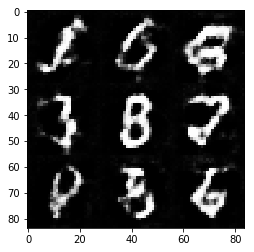

Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.5070
Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 0.6066... Generator Loss: 1.3286
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 1.3516
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.5868
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.6923


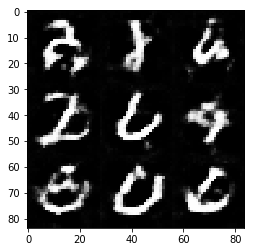

Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 2.2646
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 2.1686
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 1.7757
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 1.1842
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 2.4008
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 1.7629


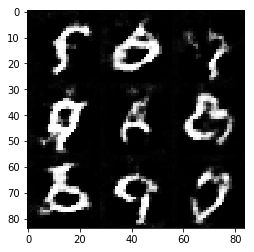

Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 0.9752
Epoch 1/2... Discriminator Loss: 0.6619... Generator Loss: 1.2509
Epoch 1/2... Discriminator Loss: 0.5443... Generator Loss: 1.3550
Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 0.9771
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.4048
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.6782
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 0.6711... Generator Loss: 2.0468
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 0.8368


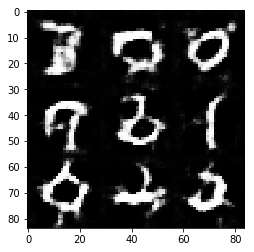

Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 2.5788
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 0.5512... Generator Loss: 1.9347
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.4913


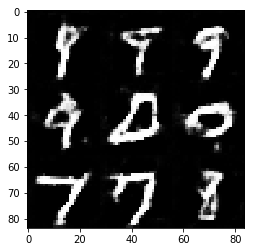

Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.4291
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 2.2165
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 0.8826
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 1.8250
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 1.4238


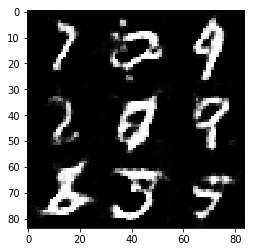

Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.1495
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 0.8909... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.3052
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.3469
Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 2.4781
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.0695


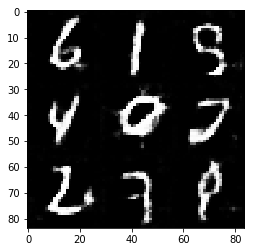

Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.4367
Epoch 1/2... Discriminator Loss: 2.1650... Generator Loss: 0.1677
Epoch 1/2... Discriminator Loss: 0.6776... Generator Loss: 1.1317
Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 0.6973


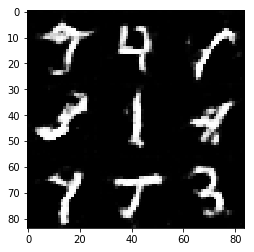

Epoch 1/2... Discriminator Loss: 0.6721... Generator Loss: 1.2569
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 1.8276
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 1.4244
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 1.4570
Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 1.1711
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.3459


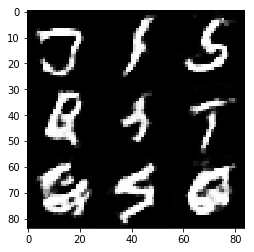

Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 1.5323
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 1.6232
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 1.3919
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 0.4719... Generator Loss: 1.4090
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 0.5799


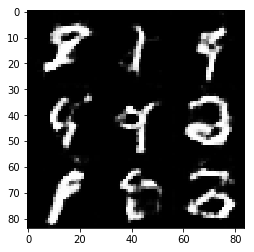

Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 2.0963
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 0.8990
Epoch 1/2... Discriminator Loss: 0.5783... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 0.5015... Generator Loss: 1.4788
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 1.2546
Epoch 2/2... Discriminator Loss: 0.4289... Generator Loss: 1.4580
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 0.5289
Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 0.6940


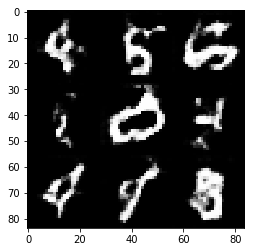

Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 1.2889
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.8688
Epoch 2/2... Discriminator Loss: 0.5927... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 0.5690... Generator Loss: 1.2317
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 0.5849
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.4599
Epoch 2/2... Discriminator Loss: 2.5036... Generator Loss: 5.5307
Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 0.8568


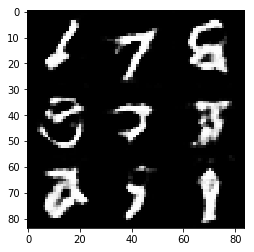

Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 1.6438
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 1.5858
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 1.4812
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 0.4700... Generator Loss: 1.5168
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.4897... Generator Loss: 1.2847


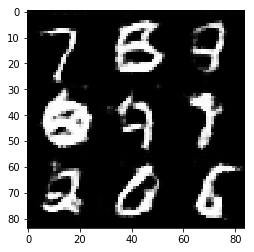

Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 0.9480
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 1.2903
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.4949
Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 1.5648
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.6179... Generator Loss: 0.3239


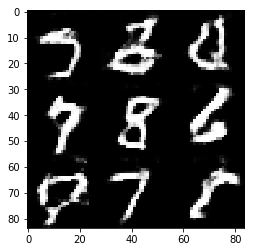

Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.4302
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 2.7025
Epoch 2/2... Discriminator Loss: 0.4297... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 0.5477... Generator Loss: 1.2311
Epoch 2/2... Discriminator Loss: 0.4939... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 6.5851... Generator Loss: 7.3544
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 2.5405
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 1.2105


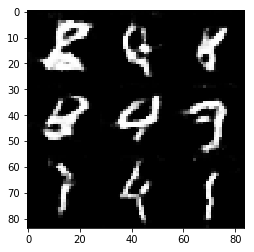

Epoch 2/2... Discriminator Loss: 0.4501... Generator Loss: 1.2500
Epoch 2/2... Discriminator Loss: 0.4771... Generator Loss: 1.2487
Epoch 2/2... Discriminator Loss: 0.4505... Generator Loss: 1.4657
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 0.9462
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.1094
Epoch 2/2... Discriminator Loss: 0.4876... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 1.5291
Epoch 2/2... Discriminator Loss: 0.6209... Generator Loss: 0.9775


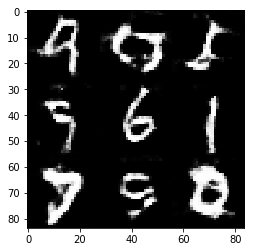

Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.1126
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 3.5397
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 0.4840... Generator Loss: 1.3081
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 1.0169
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.0279


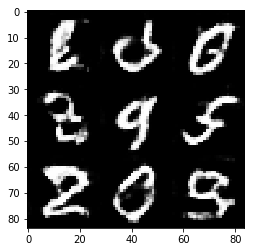

Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 0.5502... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 1.8858
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 0.4031... Generator Loss: 1.4648
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.5682
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 1.5077


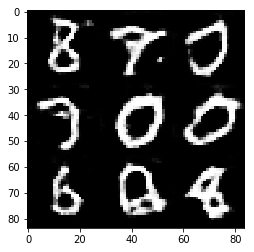

Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 0.5509... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.7246
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 0.6265... Generator Loss: 1.0108
Epoch 2/2... Discriminator Loss: 0.5244... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 1.3551
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 0.4941... Generator Loss: 1.5627


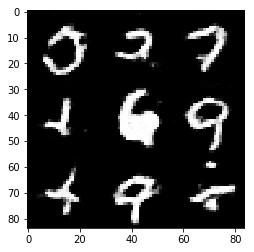

Epoch 2/2... Discriminator Loss: 1.2925... Generator Loss: 0.4139
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 2.4468
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 0.8252
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 3.2510


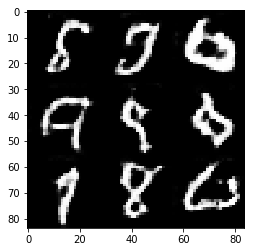

Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.8992
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 1.3267
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 1.6336
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 0.8128
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.7134
Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 0.5717... Generator Loss: 1.1475
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 1.0232
Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 1.4278


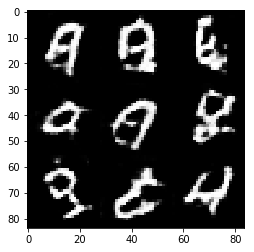

Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 1.3461
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 0.4615... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 0.3328... Generator Loss: 1.9229
Epoch 2/2... Discriminator Loss: 2.7264... Generator Loss: 0.1147
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.5131


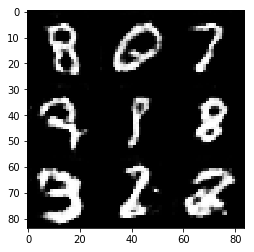

Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 1.7166
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.3105
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 1.3159
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 0.9410


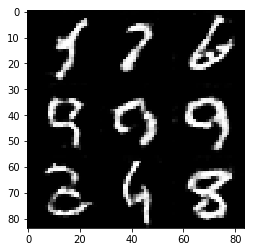

Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 1.4241
Epoch 2/2... Discriminator Loss: 0.4624... Generator Loss: 1.8599
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 0.6509... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 0.6281... Generator Loss: 1.0998
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 1.0034


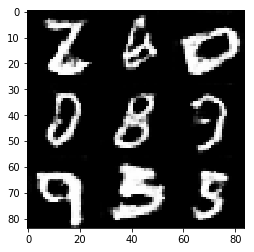

Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.5040
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 1.1526
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.6097
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 1.5502
Epoch 2/2... Discriminator Loss: 0.4755... Generator Loss: 1.3567
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 4.9351
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.2471


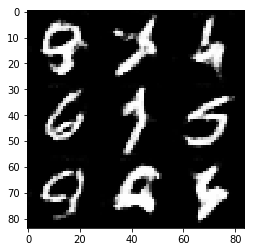

Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.0388
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 2.0033
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 0.5425... Generator Loss: 1.0907
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 3.3621
Epoch 2/2... Discriminator Loss: 0.4339... Generator Loss: 1.3721


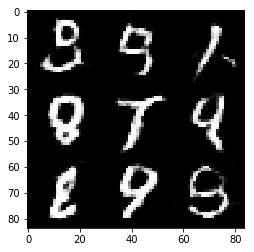

Epoch 2/2... Discriminator Loss: 0.3709... Generator Loss: 1.6239
Epoch 2/2... Discriminator Loss: 0.7045... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 1.3567
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 1.3948
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 0.3947... Generator Loss: 2.9188
Epoch 2/2... Discriminator Loss: 0.4128... Generator Loss: 1.3995
Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 1.3347


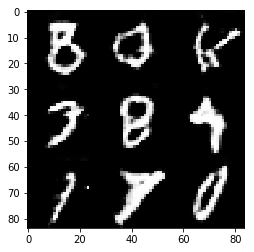

Epoch 2/2... Discriminator Loss: 1.6091... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 3.5221
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 0.4816... Generator Loss: 1.5954
Epoch 2/2... Discriminator Loss: 0.5890... Generator Loss: 1.1601
Epoch 2/2... Discriminator Loss: 0.4891... Generator Loss: 1.1860
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 0.7182
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 0.4368... Generator Loss: 1.3743


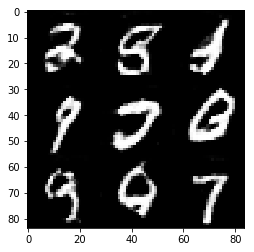

Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 1.9551
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 0.3658... Generator Loss: 1.9139
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 0.3754... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 1.6245
Epoch 2/2... Discriminator Loss: 0.2909... Generator Loss: 1.8274
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.3816
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 1.1955
Epoch 2/2... Discriminator Loss: 1.7935... Generator Loss: 0.2522


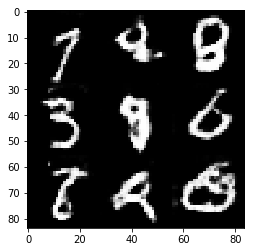

Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.0080
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 1.7273
Epoch 2/2... Discriminator Loss: 0.3444... Generator Loss: 1.6684


In [21]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 1.6351
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 2.3947
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 2.9080
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 2.4969
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 1.9193


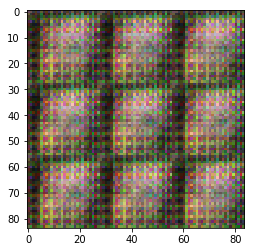

Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 2.0958
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 4.2150
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 2.6832
Epoch 1/1... Discriminator Loss: 0.1343... Generator Loss: 2.9321
Epoch 1/1... Discriminator Loss: 0.1955... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 2.5391
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.2436


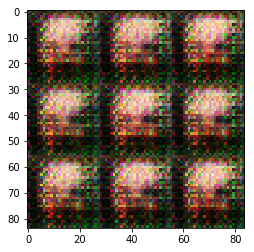

Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 0.2079... Generator Loss: 2.0997
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 3.1967
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 2.7496
Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 2.8656
Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 3.1526
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 3.0809
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 1.7686
Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 3.1897
Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 5.0181


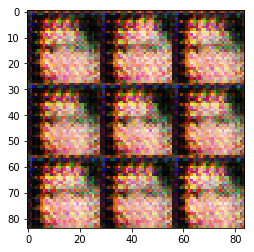

Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.2101
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 3.3128
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.2391
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 4.1074
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 6.5778
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 1.8976
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 2.0155
Epoch 1/1... Discriminator Loss: 0.2909... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 2.6763


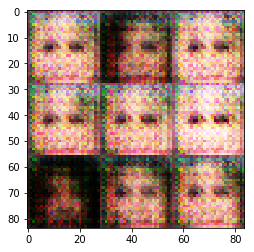

Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 2.2384
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 4.1116


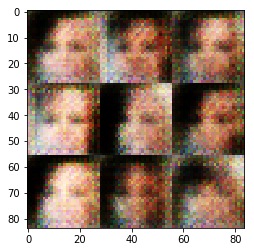

Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 2.9647
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.6550
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.9922
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.0520


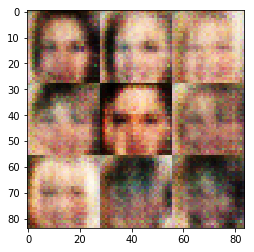

Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 2.0925
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 2.1762
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.4834
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 2.8166
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 2.6584


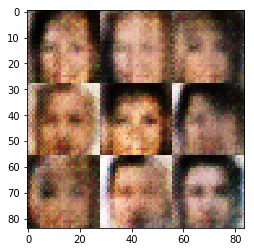

Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.3182


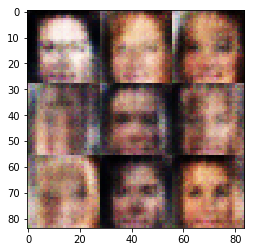

Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.8579


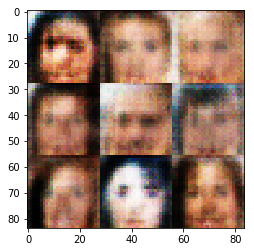

Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.7854
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.3668


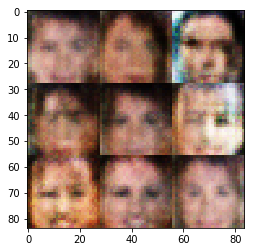

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.9896
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.7563


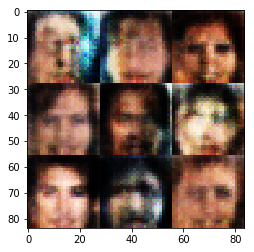

Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.8927


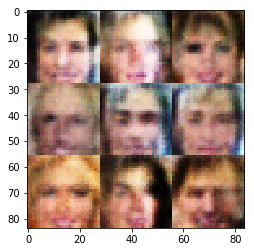

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.9928


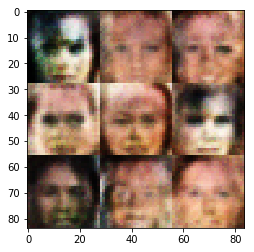

Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.6383
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.2925


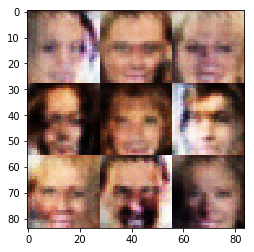

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.0664


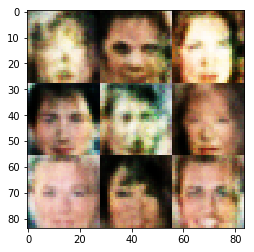

Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.6166


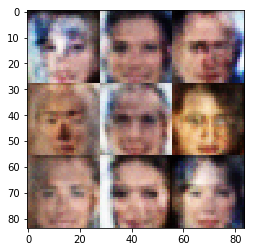

Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.5523


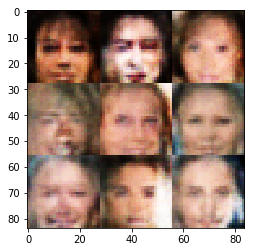

Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.4777
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.5544


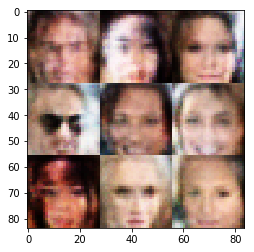

Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.3406


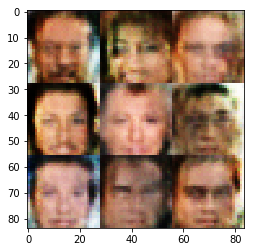

Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.8027


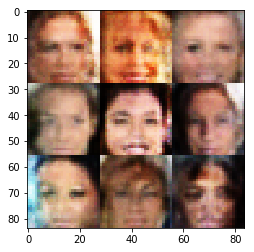

Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.8129


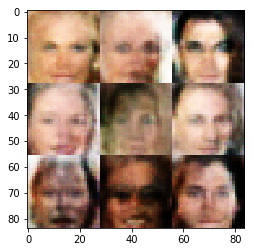

Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.1867


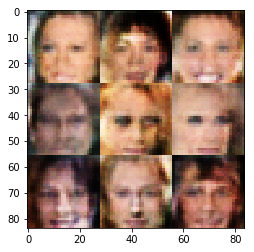

Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.3223
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.1721


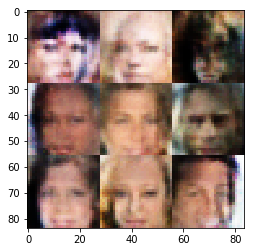

Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.7385


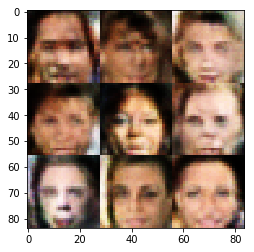

Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.1315


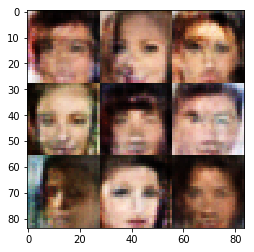

Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 0.8670


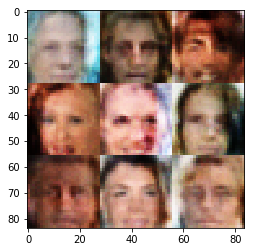

Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9063


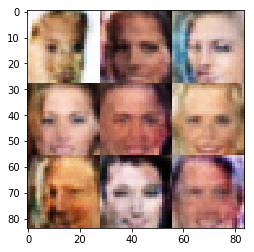

Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6505


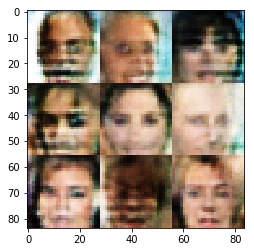

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.4336


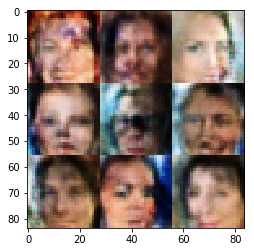

Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.8048


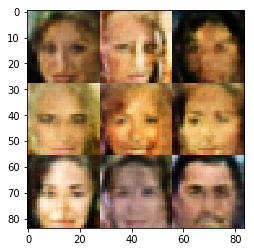

Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.2474


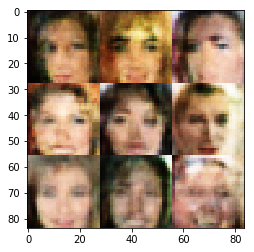

Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 0.7847


In [22]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.